In [0]:
#@title Default title text
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Average AR

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
import sys

class AR_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        # print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        # print('Persistent Model RMSE: %.3f' % rmse)     
        

    @classmethod
    def from_DataFrame(cls,dataframe, train_rate) -> 'AR_Compact':
    	return cls(dataframe, train_rate)

    @classmethod
    def from_file(cls, file: str, train_rate) -> 'AR_Compact':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df, train_rate)

    
    def __init__(self,df, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        # self.create_persistence()

        # X = (self.dataframe['t+1'] - self.dataframe['t']).values
        X = series.values

        self.train, self.test = X[1:self.train_size], X[self.train_size:]

          
    def fit(self, verbose=False):
        self.model = AR(self.train)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params  
        if verbose:      
            print('Lag: %s' % self.model_fit.k_ar)
            print('Coefficients: %s' % self.model_fit.params)

    
    def predict(self):
        self.history = self.train[len(self.train)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test)):
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            yhat = self.coef[0]
            for d in range(self.window):
                yhat += self.coef[d+1] * lag[self.window-d-1]
            obs = self.test[t]
            self.predictions.append(yhat)
            self.history.append(obs)        
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        # rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)
    def plot(self):
        # plot predicted error
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test,color ='blue', linewidth=0.5)
        pyplot.plot(self.predictions, color='green',  linewidth=0.5)
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()

    # def plot(self):
    #     # plot predicted error
    #     indices = self.df[self.df['is_anomaly']==1].index >self.train_size
    #     pyplot.figure(figsize=(50,5))
    #     pyplot.plot(self.test, color='green',  linewidth=0.5,label='True Values')
    #     pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
    #     pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
    #     pyplot.plot(self.df[self.df['is_anomaly']==1].index[indices] - self.train_size, self.test[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size -1], linestyle="",marker=".", label='Anomalies')
    #     pyplot.legend()
    #     pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A4Benchmark/A4Benchmark-TS18.csv', 0.3)
# ar_model.fit()
# ar_model.predict()
# ar_model.plot()
# ar_model.get_roc_auc(verbose=True)

def concatenate_errors(ar_univariates, dimension):
    pci_ = ar_univariates[0]
    errors = np.zeros((len(pci_.errors),dimension))
    errors[:,0] = pci_.errors.T
    # for i in range(1,5):
    for i in range(1,dimension):
        errors[:,0:i+1] = np.c_[errors[:,:i],ar_univariates[i].errors.reshape(-1,1)]
    return np.min(errors,axis=1)


## Evaluation

In [0]:

import datetime
startTime = datetime.datetime.now()
dimension = 5
# df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
ar_univariates = []
for i in range (5):
    print(i)
    df_univariate = pd.DataFrame(np.c_[df_synthetic.iloc[:,i].values,df_synthetic.iloc[:,-1].values])
    df_univariate.columns = ['V1','is_anomaly']
    ar = AR_Compact.from_DataFrame(df_univariate,0.3)
    # ar.getAndReadAnaomaliesByPCI(plot=False)
    ar.fit()
    ar.predict()
    ar_univariates.append(ar)
	
errors = concatenate_errors(ar_univariates)
ar_full = AR_Compact.from_DataFrame(df_synthetic,0.3)
ar_full.errors = errors
ar_full.get_roc_auc(verbose=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.microseconds/1000, 'ms')

0


NameError: ignored

0


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


1


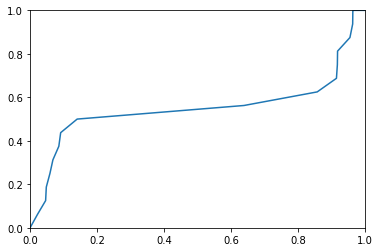

AUC:  0.5490260471400693
Time:  0:00:24.144307


In [0]:
def concatenate_errors(ar_univariates, dimension):
    pci_ = ar_univariates[0]
    errors = np.zeros((len(pci_.errors),dimension))
    errors[:,0] = pci_.errors.T
    # for i in range(1,5):
    for i in range(1,dimension):
        errors[:,0:i+1] = np.c_[errors[:,:i],ar_univariates[i].errors.reshape(-1,1)]
    return np.max(errors,axis=1)

import datetime
startTime = datetime.datetime.now()

dimension = 2
# df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
ar_univariates = []
df_stmp = read_csv('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv', header=0, index_col=0, parse_dates=True,squeeze=True)
df_stmp.rename(columns={'Target':'is_anomaly'}, inplace=True)
df_stmp.loc[df_stmp.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
df_stmp.loc[df_stmp.is_anomaly == "'Normal'", 'is_anomaly'] = 0

for i in range (dimension):
    print(i)
    df_univariate = pd.DataFrame(np.c_[df_stmp.iloc[:,i].values,df_stmp.iloc[:,-1].values])
    df_univariate.columns = ['V1','is_anomaly']
    ar = AR_Compact.from_DataFrame(df_univariate,0.3)
    # ar.getAndReadAnaomaliesByPCI(plot=False)
    ar.fit()
    ar.predict()
    ar_univariates.append(ar)
	
errors = concatenate_errors(ar_univariates,dimension)
ar_full = AR_Compact.from_DataFrame(df_stmp,0.3)
ar_full.errors = errors
ar_full.get_roc_auc(verbose=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

# Average MA

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
import sys

class MA_Average:

    @classmethod
    def from_DataFrame(cls,dataframe, train_rate) -> 'MA':
    	return cls(dataframe, train_rate)

    @classmethod
    def from_file(cls, file: str, train_rate) -> 'MA':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df, train_rate)

    
    def __init__(self,df, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        X = self.dataframe.values
        self.train_size = int(len(X) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        # self.create_persistence()

        # X = (self.dataframe['t+1'] - self.dataframe['t']).values
        X = series.values

        # persistence model on training set
        self.train_pred = [x for x in self.train_X]
        # calculate residuals
        self.train_resid = [self.train_y[i]-self.train_pred[i] for i in range(len(self.train_pred))]

    # def __init__(self, path, train_rate):

    #     self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    #     self.df = self.df.reset_index(drop=True)
    #     self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
    #     series = pd.DataFrame(self.df.iloc[:,0].values)  
    #     self.values = DataFrame(series.values)
    #     self.dataframe = concat([self.values.shift(1), self.values], axis=1)
    #     self.dataframe.columns = ['t', 't+1']
    #     X = self.dataframe.values

    #     self.train_size = int(len(X) * train_rate)    

    #     train, test = X[1:self.train_size], X[self.train_size:]
    #     self.train_X, self.train_y = train[:,0], train[:,1]
    #     self.test_X, self.test_y = test[:,0], test[:,1]        
    #     # persistence model on training set
    #     self.train_pred = [x for x in self.train_X]
    #     # calculate residuals
    #     self.train_resid = [self.train_y[i]-self.train_pred[i] for i in range(len(self.train_pred))]

    def fit(self, verbose=False):
        self.model = AR(self.train_resid)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params        
        if verbose:
            print(self.coef)

    def predict(self):
        # walk forward over time steps in test
        self.history = self.train_resid[len(self.train_resid)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test_y)):
            # persistence
            yhat = self.test_X[t]
            error = self.test_y[t] - yhat
            # predict error
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            pred_error = self.coef[0]
            for d in range(self.window):
                pred_error += self.coef[d+1] * lag[self.window-d-1]
            # correct the prediction
            yhat = yhat + pred_error
            self.predictions.append(yhat)
            self.history.append(error)
            # print('predicted=%f, expected=%f' % (yhat, test_y[t]))
        rmse = sqrt(mean_squared_error(self.test_y, self.predictions))
        self.errors = np.absolute(self.test_y - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y,color ='blue', linewidth=0.5)
        pyplot.plot(self.predictions, color='green',  linewidth=0.5)
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()


    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index - self.train_size ]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)


# ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A4Benchmark/A4Benchmark-TS18.csv', 0.3)
# ar_model.fit()
# ar_model.predict()
# ar_model.plot()
# ar_model.get_roc_auc(verbose=True)



## Evaluation

0


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


1


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


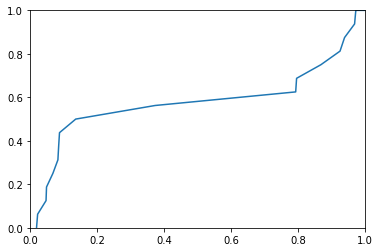

AUC:  0.5783694265125358
Time:  0:00:04.795467


In [0]:

import datetime
startTime = datetime.datetime.now()

def concatenate_errors(ar_univariates, dimension):
    pci_ = ar_univariates[0]
    errors = np.zeros((len(pci_.errors),dimension))
    errors[:,0] = pci_.errors.T
    # for i in range(1,5):
    for i in range(1,dimension):
        errors[:,0:i+1] = np.c_[errors[:,:i],ar_univariates[i].errors.reshape(-1,1)]
    return np.mean(errors,axis=1)

dimension = 2
# df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
ar_univariates = []
df_stmp = read_csv('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv', header=0, index_col=0, parse_dates=True,squeeze=True)
df_stmp.rename(columns={'Target':'is_anomaly'}, inplace=True)
df_stmp.loc[df_stmp.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
df_stmp.loc[df_stmp.is_anomaly == "'Normal'", 'is_anomaly'] = 0

for i in range (dimension):
    print(i)
    df_univariate = pd.DataFrame(np.c_[df_stmp.iloc[:,i].values,df_stmp.iloc[:,-1].values])
    df_univariate.columns = ['V1','is_anomaly']
    ar = MA_Average.from_DataFrame(df_univariate,0.3)
    # ar.getAndReadAnaomaliesByPCI(plot=False)
    ar.fit()
    ar.predict()
    ar_univariates.append(ar)
	
errors = concatenate_errors(ar_univariates,dimension)
ar_full = MA_Average.from_DataFrame(df_stmp,0.3)
ar_full.errors = errors
ar_full.get_roc_auc(verbose=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

# Average XGBoost

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys

class XGBRegressor_Average_AnomalyDetection:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, train_rate) -> 'XGBRegressor_AnomalyDetection':
    	return cls(dataframe, window_width, train_rate)

    @classmethod
    def from_file(cls, path, window_width, train_rate) -> 'XGBRegressor_AnomalyDetection':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df,window_width, train_rate)
         
    def __init__(self,df, window_width, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.__build_sets()
                
        self.compute_anomalyScores()
    
    def getWindowedVectors(self, X):
        vectors = []
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors.append(X[i:i+self.window_width])
        return vectors

    def compute_anomalyScores(self):

        xgb = XGBRegressor()
        xgb.fit(self.train_X.reshape(-1,1),self.train_y.reshape(-1,1))

        self.predictions = xgb.predict(self.test_X.reshape(-1,1))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
#         print('Prediction Test RMSE: %.3f' % rmse)
    

    def plot(self):
        # plot predicted error
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        pyplot.plot(self.predictions, color='blue')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A4Benchmark/A4Benchmark-TS18.csv', 0.3)
# ar_model.fit()
# ar_model.predict()
# ar_model.plot()
# ar_model.get_roc_auc(verbose=True)




## Evaluate

0
[12:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1
[12:05:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


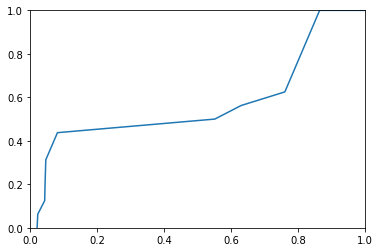

AUC:  0.5747091277585948
Time:  0:00:01.697473


In [0]:
def concatenate_errors(ar_univariates, dimension):
    pci_ = ar_univariates[0]
    errors = np.zeros((len(pci_.errors),dimension))
    errors[:,0] = pci_.errors.T
    # for i in range(1,5):
    for i in range(1,dimension):
        errors[:,0:i+1] = np.c_[errors[:,:i],ar_univariates[i].errors.reshape(-1,1)]
    return np.mean(errors,axis=1)


import datetime
startTime = datetime.datetime.now()

dimension = 2
# df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
ar_univariates = []
df_stmp = read_csv('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv', header=0, index_col=0, parse_dates=True,squeeze=True)
df_stmp.rename(columns={'Target':'is_anomaly'}, inplace=True)
df_stmp.loc[df_stmp.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
df_stmp.loc[df_stmp.is_anomaly == "'Normal'", 'is_anomaly'] = 0

for i in range (dimension):
    print(i)
    df_univariate = pd.DataFrame(np.c_[df_stmp.iloc[:,i].values,df_stmp.iloc[:,-1].values])
    df_univariate.columns = ['V1','is_anomaly']
    ar = XGBRegressor_Average_AnomalyDetection.from_DataFrame(df_univariate,100,0.3)
    # ar.getAndReadAnaomaliesByPCI(plot=False)
    ar.fit()
    ar_univariates.append(ar)
	
errors = concatenate_errors(ar_univariates,dimension)
ar_full = XGBRegressor_Average_AnomalyDetection.from_DataFrame(df_stmp,100,0.3)
ar_full.errors = errors
ar_full.get_roc_auc(verbose=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

# Average OCSVM

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
import sys

class OneClassSVM_Average_AnomalyDetection:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, nu, train_rate) -> 'OneClassSVM_AnomalyDetection':
    	return cls(dataframe, window_width, nu, train_rate)

    @classmethod
    def from_file(cls, path, window_width, nu, train_rate) -> 'OneClassSVM_AnomalyDetection':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df,window_width, nu, train_rate)
     
    def __init__(self,df, window_width, nu, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        self.nu = nu
        self.window_width = window_width
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        # train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        # self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        # self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]     
        # self.create_persistence()

        # X = series.values
        # self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def __build_sets(self):
        train_labeled, test_labeled = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = train_labeled[:,0], train_labeled[:,1]
        self.test_X, self.test_y = test_labeled[:,0], test_labeled[:,1]   

        X = self.dataframe.iloc[:,1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    

    def standardize_dataframe(self):
        X = self.dataframe.values
        self.scalar = preprocessing.StandardScaler().fit(X)
        X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(X)

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(X)



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe['t'].iloc[self.train_size:], self.dataframe['t+1'].iloc[self.train_size::]))
#         print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.__build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
    
    def getWindowedVectors(self, X):
        vectors = []
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors.append(X[i:i+self.window_width])
        return vectors

    def compute_anomalyScores(self):
        self.errors = np.zeros_like(self.test)
        # compute anomalies
        warnings.filterwarnings("ignore")

        # history = self.getWindowedVectors(self.train)

        for i,_ in enumerate(self.test[:-self.window_width+1]):
            sys.stdout.write('\r'+str(i)+':'+str(len(self.test) - self.window_width))

            window = self.test[i:i+self.window_width]
            window2D = np.zeros((len(window),2))
            window2D[:,1] = window
            clf=OneClassSVM(nu=self.nu)
            clf.fit(window2D)
            error = clf.decision_function(window2D) 
            error[error>0] = 0
            self.errors[i:i+self.window_width] += error*-10


        # normalize anomaly score
        self.errors[:-self.window_width+1] /= self.window_width
        for i,error in enumerate(self.test[-self.window_width+1:]):
            self.errors[-self.window_width + 1 + i] /=self.window_width-(i+1)

        # self.errors_original = self.errors
        # scalar = preprocessing.MinMaxScaler((0,1)).fit(self.errors.reshape(-1,1))
        # self.errors = scalar.transform(self.errors.reshape(-1,1))*10


    def plot(self):
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)


# iforest = OneClassSVM_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv',30,0.7,0.3)
# iforest.fit()
# iforest.plot()
# iforest.get_roc_auc(verbose=False)



## Evaluation

0
66580:665801
66580:66580

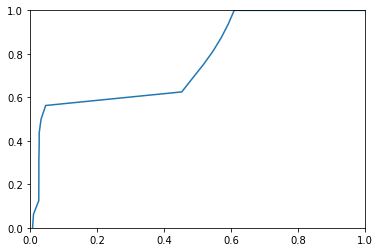

AUC:  0.7670920282239904
Time:  103.846792 ms


In [0]:
def concatenate_errors(ar_univariates, dimension):
    pci_ = ar_univariates[0]
    errors = np.zeros((len(pci_.errors),dimension))
    errors[:,0] = pci_.errors.T
    # for i in range(1,5):
    for i in range(1,dimension):
        errors[:,0:i+1] = np.c_[errors[:,:i],ar_univariates[i].errors.reshape(-1,1)]
    return np.mean(errors,axis=1)


import datetime
startTime = datetime.datetime.now()

dimension = 2
# df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
ar_univariates = []
df_stmp = read_csv('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv', header=0, index_col=0, parse_dates=True,squeeze=True)
df_stmp.rename(columns={'Target':'is_anomaly'}, inplace=True)
df_stmp.loc[df_stmp.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
df_stmp.loc[df_stmp.is_anomaly == "'Normal'", 'is_anomaly'] = 0

# df = read_csv(path, header=0, index_col=index_col, parse_dates=True,squeeze=True)
ar_univariates = []
for i in range (dimension):
    print(i)
    df_univariate = pd.DataFrame(np.c_[df_stmp.iloc[:,i].values,df_stmp.iloc[:,-1].values])
    df_univariate.columns = ['V1','is_anomaly']
    ar = OneClassSVM_Average_AnomalyDetection.from_DataFrame(df_univariate,30,0.7,0.3)
    # ar.getAndReadAnaomaliesByPCI(plot=False)
    ar.fit()
    ar_univariates.append(ar)
	
errors = concatenate_errors(ar_univariates,dimension)
ar_full = OneClassSVM_Average_AnomalyDetection.from_DataFrame(df_stmp,30,0.7,0.3)
ar_full.errors = errors
ar_full.get_roc_auc(verbose=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff.total_seconds(), 'ms')

# iforest = XGBRegressor_AnomalyDetection('Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv',30,0.7,0.66)
# iforest.fit()
# iforest.plot()
# iforest.get_roc_auc(verbose=False)

# Projection

In [0]:
import warnings
from sklearn.cluster import KMeans
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from xgboost import XGBRegressor
from sklearn import preprocessing
import sys
from tensorflow import set_random_seed
set_random_seed(42)
from numpy.random import seed
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.layers import Conv1D,MaxPooling1D,Flatten
seed(42)
from keras import regularizers

def warn(*args, **kwargs):
    pass
    
class Projection_AnomalyDetection:

    @classmethod
    def from_DataFrame(cls,dataframe,window_width, dimension, train_rate) -> 'Projection_AnomalyDetection':
    	return cls(dataframe, window_width, dimension, train_rate)

    @classmethod
    def from_file(cls, path, window_width, dimension, train_rate) -> 'Projection_AnomalyDetection':
    	df = read_csv(path, header=0, index_col=None, parse_dates=True,squeeze=True)
    	return cls(df,window_width, dimension, train_rate)
         
    # def __init__(self,path, window_width, dimension, train_rate):

    #     self.dimension = dimension
    #     self.n_epochs = n_epochs
    #     self.window_width = window_width
        
    #     self.n_filters = n_filters
    #     self.kernel_size = kernel_size
    #     self.n_dense = n_dense

    #     self.df = read_csv(path, header=0, index_col=None, parse_dates=True,squeeze=True)
    #     self.df = self.df.reset_index(drop=True)
    #     self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
    #     self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
    #     self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0
        
    #     self.X_origin = self.df.iloc[:,:dimension].values
    #     self.Y_origin = self.df.iloc[:,-1].values

    #     df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
    #     self.values = df_sensors
    #     self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
    #     self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,10)]),np.array(['V'+str(i)+'_t+1' for i in range(1,10)]),['is_anomaly']]

    #     # self.dataframe = concat([self.values.shift(1), self.values], axis=1)
    #     # self.dataframe.columns = ['t', 't+1']

    #     self.train_size = int(len(self.values) * train_rate)  

    def __init__(self,dataframe, window_width, dimension, train_rate):

        self.df = dataframe
        self.dimension = dimension
        self.window_width = window_width
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        self.X_origin = self.df.iloc[:,:dimension].values
        self.Y_origin = self.df.iloc[:,-1].values

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]



        # self.train_size = int(len(self.values) * train_rate)   

    def reset_dataframe(self, dataframe, dimension, window_width, train_rate):
        self.df = ddataframef
        self.dimension = dimension
        self.window_width = window_width
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'Target':'is_anomaly'}, inplace=True)
        self.df.loc[self.df.is_anomaly == "'Anomaly'", 'is_anomaly'] = 1
        self.df.loc[self.df.is_anomaly == "'Normal'", 'is_anomaly'] = 0

        df_sensors = pd.DataFrame(self.df.iloc[:,:dimension].values)  
        self.values = df_sensors
        self.dataframe = concat([self.df.iloc[:,:-1].shift(1), self.df.iloc[:,:-1], self.df.iloc[:,-1]], axis=1)
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]



        self.train_size = int(len(self.values) * train_rate)   

    def create_XY_lookback_dataset(self,dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),:self.dimension]
            dataX.append(a)
            dataY.append(dataset[i + look_back,:self.dimension].reshape(-1))
        return numpy.array(dataX), numpy.array(dataY)
    
    def getWindowedVectors(self, X):
        vectors = np.zeros((len(X) - self.window_width+1,self.window_width))
        for i,_ in enumerate(X[:-self.window_width+1]):
            vectors[i] = X[i:i+self.window_width]
        return vectors




    def build_sets(self):

        self.X = self.dataframe.iloc[:,:-1].values
        self.Y = self.dataframe.iloc[:,-1].values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]    
        # print('Train.len:',len(self.train),' - Test.len:', len(self.test))

        self.train_X, self.train_y = self.create_XY_lookback_dataset(self.train, self.window_width)
        self.test_X, self.test_y = self.create_XY_lookback_dataset(self.test, self.window_width)
        # print('TrainX.shape:',self.train_X.shape,' - TestX.shape:', self.test_X.shape,' - TrainY.shape:', self.train_y.shape,' - TestY.shape:', self.test_y.shape)

        self.validationsize = int(self.train_X.shape[0] * 0.1)
        self.val, self.test = self.test[:self.validationsize], self.test[self.validationsize:]
        self.val_X, self.val_y= self.test_X[:self.validationsize], self.test_y[:self.validationsize]
        self.test_X, self.test_y = self.test_X[self.validationsize:], self.test_y[self.validationsize:]
        
    def standardize_dataframe(self):

        self.scalar = preprocessing.StandardScaler().fit(X)
        self.X = self.scalar.transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]

    def inverse_standardize_dataframe(self):
        X = self.dataframe.values[:,:-1]
        X = self.scalar.inverse_transform(X)
        self.dataframe = pd.DataFrame(np.concatenate((X,self.dataframe.values[:,-1].reshape(-1,1)),axis=1))
        self.dataframe.columns = np.r_[np.array(['V'+str(i)+'_t' for i in range(1,self.dimension+1)]),np.array(['V'+str(i)+'_t+1' for i in range(1,self.dimension+1)]),['is_anomaly']]



    def model_persistence(self, x):
        return x
        
    def create_persistence(self):
        rmse = sqrt(mean_squared_error(self.dataframe.iloc[self.train_size:,:self.dimension], self.dataframe.iloc[self.train_size:,self.dimension:-1]))
        # print('Persistent Model RMSE: %.3f' % rmse)   

    def fit(self):
        self.create_persistence()
        self.standardize_dataframe()
        self.build_sets()
                
        self.compute_anomalyScores()
        self.inverse_standardize_dataframe()
        self.compute_Errors_RMSE()


    def plotTraining(self):
        history_dict = self.history.history
        loss_values = history_dict['loss'][1:]
        val_loss_values = history_dict['val_loss'][1:]
        self.n_epochs = range(2, self.n_epochs + 1)
        plt.plot(self.n_epochs, loss_values, 'bo', label='Training loss')
        plt.plot(self.n_epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def getchange(self, V_0,V_1):
        Matrix = V_1.T@V_0@V_0.T@V_1
        eigenvalues = np.linalg.eig(Matrix)[0]
        lambda_min = np.min(eigenvalues)
        return np.sqrt(max((1-lambda_min),0))
        
    def get_projected_Dataframe(self):
        changes_anomaly = np.empty((len(self.X_origin)-self.window_width-1,2))
        for i in range(len(self.X_origin)-self.window_width-1):
            W_0 = self.X_origin[i:i+self.window_width]
            W_1 = self.X_origin[i+1:i+self.window_width+1]
            changes_anomaly[i] = [self.getchange(W_0,W_1),self.Y_origin[i]]         
        return pd.DataFrame(changes_anomaly)

    def compute_anomalyScores(self):

        changes_anomaly = np.empty((len(self.train_X)-self.window_width-1,1))
        for i in range(len(self.X)-window_width-1):
            W_0 = self.X[i:i+window_width]
            W_1 = self.X[i+1:i+window_width+1]
            changes_anomaly[i] = [getchange(W_0,W_1),self.Y[i]]    

        # self.train_X = numpy.reshape(self.train_X, (self.train_X.shape[0],self.dimension,self.train_X.shape[1]))
        # self.test_X = numpy.reshape(self.test_X, (self.test_X.shape[0],self.dimension, self.test_X.shape[1]))

        from keras.layers import Conv1D,MaxPooling1D,Flatten
        self.model = Sequential()

        self.model = Sequential()
        self.model.add(LSTM(self.n_filters[0], batch_input_shape=(1, self.window_width, self.dimension), stateful=True, return_sequences=True))
        self.model.add(LSTM(self.n_filters[1], batch_input_shape=(1, self.window_width, self.dimension), stateful=True))
        self.model.add(Dense(self.dimension))
        self.model.compile(optimizer='adam', loss='mse')
        for i in range(self.n_epochs):
            sys.stdout.write('\r'+str(i)+':'+str(self.n_epochs))
            self.model.fit(self.train_X, self.train_y,validation_data=(self.val_X,self.val_y), epochs=1, batch_size=1, verbose=0, shuffle=False)
            self.model.reset_states()
        print('')

        # self.plotTraining()
        self.predictions = self.model.predict(self.test_X, batch_size = 1)


    def compute_Errors_RMSE(self):

        rmse = sqrt(mean_squared_error(self.test_y.reshape(self.predictions.shape), self.predictions))
        self.errors = np.absolute(self.test_y.reshape(self.predictions.shape) - np.array(self.predictions))
        # print('Prediction Test RMS        E: %.3f' % rmse)       
   

    def plot(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(50,5))
        for i, ax in enumerate(axes.flatten()):
            data = self.df[self.df.columns[i]].iloc[:200]
            ax.plot(self.test_y[:,i], color='green',  linewidth=0.5,label='True Values')
            ax.plot(self.predictions[:,i], color='blue',  linewidth=0.5,label='Predictions')
            ax.plot(self.errors[:,i], color = 'red',  linewidth=0.5, label='Errors')
            ax.legend()
            
        plt.show()

    def get_roc_auc(self, plot=True, verbose=True):
        self.euclidean_errors = numpy.linalg.norm(self.test_y.reshape(self.predictions.shape) - self.predictions, axis=1)
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size + self.validationsize
        true_anomaly_predicted_errors = self.euclidean_errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size - self.validationsize - self.window_width -1]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.euclidean_errors[self.euclidean_errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.euclidean_errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# filters = [[8,8,8,8], [4,4,4,4], [4,8,16,32], [16,32,48,64],  [32,64,12,24],[128,128,128,128],[64,64,64,64],[256,256,256,256],[128,256,512,1024]]
# kernelsizes = [2,3,4,6,8,16]
# dense = [18,36,72,144]

# best_auc = [0,0]
# histories = []
# for f in filters:
#     for k in kernelsizes:
#         for d in dense:

#             cnn = WaveNet_AnomalyDetection('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40902.csv',30,9,20,0.3,f,k,d)
#             hist = cnn.fit()
#             histories.append(((f,k,d), hist))
#             # cnn.plot()
#             auc = cnn.get_roc_auc(verbose=False,plot=False)
#             print(' auc:', auc, ' - f:', f, ' - k:', k, ' - d:', d)
#             if best_auc[1] < auc:
#                 print('New best auc:', auc, ' - f:', f, ' - k:', k, ' - d:', d)
#                 best_auc = [(f,k,d),auc]

# filters = [[8,8,8,8], [4,4,4,4], [4,8,16,32], [16,32,48,64],  [32,64,12,24],[128,128,128,128],[64,64,64,64],[256,256,256,256],[128,256,512,1024]]
# kernelsizes = [2,3,4,6,8,16]
# dense = [18,36,72,144]


# for epochs in [50,60,70,80,100,150,200]:
#     # cnn = LSTM_AnomalyDetection('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40902.csv',30,9,20,0.3,[4,4],k,d)
#     cnn = LSTM_AnomalyDetection(dataframe=df,window_width=13,dimension=5,n_epochs=epochs,train_rate=0.3,n_filters=[7,7])
#     # cnn.reset_dataframe(df,5,13, 0.3)
#     cnn.fit()
#     # # cnn.plot()
#     auc = cnn.get_roc_auc(verbose=False,plot=True)
#     print(best_auc)
#     # 0.59 40 EPochs

Using TensorFlow backend.


## Evaluation

In [0]:
import datetime
startTime = datetime.datetime.now()
cl = Projection_AnomalyDetection.from_file('drive/My Drive/MT/Experiments/Multivariate/NASA_Shuttle/40903.csv',10,3,0.3)
df_projected = cl.get_projected_Dataframe()
df_projected.columns = ['V1','is_anomaly']
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

Time:  0:00:04.948650


### AR

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
import sys

class AR_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        # print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        # print('Persistent Model RMSE: %.3f' % rmse)     
        

    @classmethod
    def from_DataFrame(cls,dataframe, train_rate) -> 'AR_Compact':
    	return cls(dataframe, train_rate)

    @classmethod
    def from_file(cls, file: str, train_rate) -> 'AR_Compact':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df, train_rate)

    
    def __init__(self,df, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        self.create_persistence()

        # X = (self.dataframe['t+1'] - self.dataframe['t']).values
        X = series.values

        self.train, self.test = X[1:self.train_size], X[self.train_size:]

          
    def fit(self, verbose=False):
        self.model = AR(self.train)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params  
        if verbose:      
            print('Lag: %s' % self.model_fit.k_ar)
            print('Coefficients: %s' % self.model_fit.params)

    
    def predict(self):
        self.history = self.train[len(self.train)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test)):
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            yhat = self.coef[0]
            for d in range(self.window):
                yhat += self.coef[d+1] * lag[self.window-d-1]
            obs = self.test[t]
            self.predictions.append(yhat)
            self.history.append(obs)        
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)
    def plot(self):
        # plot predicted error
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test,color ='blue', linewidth=0.5)
        pyplot.plot(self.predictions, color='green',  linewidth=0.5)
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()

    # def plot(self):
    #     # plot predicted error
    #     indices = self.df[self.df['is_anomaly']==1].index >self.train_size
    #     pyplot.figure(figsize=(50,5))
    #     pyplot.plot(self.test, color='green',  linewidth=0.5,label='True Values')
    #     pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
    #     pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
    #     pyplot.plot(self.df[self.df['is_anomaly']==1].index[indices] - self.train_size, self.test[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size -1], linestyle="",marker=".", label='Anomalies')
    #     pyplot.legend()
    #     pyplot.show()

    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A4Benchmark/A4Benchmark-TS18.csv', 0.3)
# ar_model.fit()
# ar_model.predict()
# ar_model.plot()
# ar_model.get_roc_auc(verbose=True)

#### Results of SMTP

In [0]:
import datetime
startTime = datetime.datetime.now()

ar_model = AR_Compact.from_DataFrame(df_projected,0.3)
ar_model.fit()
ar_model.predict()
ar_model.get_roc_auc(verbose=False,plot=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

AUC:  0.44328483003513414
Time:  0:00:10.263810


### MA

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot

class MA:

    @classmethod
    def from_DataFrame(cls,dataframe, train_rate) -> 'MA':
    	return cls(dataframe, train_rate)

    @classmethod
    def from_file(cls, file: str, train_rate) -> 'MA':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df, train_rate)

    
    def __init__(self,df, train_rate):
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)

        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        X = self.dataframe.values
        self.train_size = int(len(X) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        # self.create_persistence()

        # X = (self.dataframe['t+1'] - self.dataframe['t']).values
        X = series.values

        # persistence model on training set
        self.train_pred = [x for x in self.train_X]
        # calculate residuals
        self.train_resid = [self.train_y[i]-self.train_pred[i] for i in range(len(self.train_pred))]

    # def __init__(self, path, train_rate):

    #     self.df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    #     self.df = self.df.reset_index(drop=True)
    #     self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
    #     series = pd.DataFrame(self.df.iloc[:,0].values)  
    #     self.values = DataFrame(series.values)
    #     self.dataframe = concat([self.values.shift(1), self.values], axis=1)
    #     self.dataframe.columns = ['t', 't+1']
    #     X = self.dataframe.values

    #     self.train_size = int(len(X) * train_rate)    

    #     train, test = X[1:self.train_size], X[self.train_size:]
    #     self.train_X, self.train_y = train[:,0], train[:,1]
    #     self.test_X, self.test_y = test[:,0], test[:,1]        
    #     # persistence model on training set
    #     self.train_pred = [x for x in self.train_X]
    #     # calculate residuals
    #     self.train_resid = [self.train_y[i]-self.train_pred[i] for i in range(len(self.train_pred))]

    def fit(self, verbose=False):
        self.model = AR(self.train_resid)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params        
        if verbose:
            print(self.coef)

    def predict(self):
        # walk forward over time steps in test
        self.history = self.train_resid[len(self.train_resid)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test_y)):
            # persistence
            yhat = self.test_X[t]
            error = self.test_y[t] - yhat
            # predict error
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            pred_error = self.coef[0]
            for d in range(self.window):
                pred_error += self.coef[d+1] * lag[self.window-d-1]
            # correct the prediction
            yhat = yhat + pred_error
            self.predictions.append(yhat)
            self.history.append(error)
            # print('predicted=%f, expected=%f' % (yhat, test_y[t]))
        rmse = sqrt(mean_squared_error(self.test_y, self.predictions))
        self.errors = np.absolute(self.test_y - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        df_test = pd.DataFrame(self.df.iloc[self.train_size:].values)

        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y,color ='blue', linewidth=0.5)
        pyplot.plot(self.predictions, color='green',  linewidth=0.5)
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5)
        pyplot.plot(df_test[df_test[1]==1.].index, df_test[df_test[1]==1.].iloc[:,0].values,'ro')
        pyplot.show()


    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index - self.train_size ]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended)]
                # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# ma_model = MA('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_14.csv',0.66)
# ma_model.fit()
# ma_model.predict()
# ma_model.plot()
# ma_model.get_roc_auc(verbose=False)

#### Results of SMTP

In [0]:
import datetime
startTime = datetime.datetime.now()

ma = MA.from_DataFrame(df_projected,0.3)
ma.fit()
ma.predict()
ma.get_roc_auc(verbose=False,plot=False)

endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff)

AUC:  0.587288576168884
Time:  0:00:02.163155


### ARIMA

In [0]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import warnings
import sys

class ARIMA_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        # print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        # print('Persistent Model RMSE: %.3f' % rmse)        

    @classmethod
    def from_DataFrame(cls,dataframe, train_rate,order) -> 'ARIMA_Compact':
    	return cls(dataframe, train_rate,order)

    @classmethod
    def from_file(cls, file: str, train_rate,order) -> 'ARIMA_Compact':
    	df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
    	return cls(df, train_rate,order)
     
    def __init__(self, df, train_rate, order):
        
        self.order = order
        self.df = df
        self.df = self.df.reset_index(drop=True)
        self.df.rename(columns={'anomaly':'is_anomaly'}, inplace=True)
        series = pd.DataFrame(self.df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']
		

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        self.create_persistence()

        X = series.values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]
        self.train = self.train.astype('float32')
        self.test = self.test.astype('float32')
          
    def fit(self,  verbose=False):
        self.model = ARIMA(self.train, order = self.order)
        self.model_fit = self.model.fit(disp=0)

    
    def predict(self):
        warnings.filterwarnings("ignore")
        self.history = [x for x in self.train]
        self.predictions = list()
        for t in range(len(self.test)):
            self.model = ARIMA(self.history,order=self.order)
            self.model = self.model.fit(disp=0)
            output = self.model.forecast()
            yhat = output[0]
            self.predictions.append(yhat)
            obs = self.test[t]
            self.history.append(obs)
            sys.stdout.write('\r'+str(t)+':'+str(len(self.test)))
        print('')    
			
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        # print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test_y, color='green',  linewidth=0.5,label='True Values')
        pyplot.plot(self.predictions, color='blue',  linewidth=0.5,label='Predictions')
        pyplot.plot(self.errors, color = 'red',  linewidth=0.5, label='Errors')
        pyplot.legend()
        pyplot.show()


    def get_roc_auc(self, plot=True, verbose=True):
        # get the predicted errors of the anomaly points
        indices = self.df[self.df['is_anomaly']==1].index >self.train_size
        true_anomaly_predicted_errors = self.errors[self.df[self.df['is_anomaly']==1].index[indices] - self.train_size ]
        if len(true_anomaly_predicted_errors) == 0:
            return np.nan
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors_extended = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],40)[:-1],true_anomaly_predicted_errors]
        true_anomaly_predicted_errors_extended = np.r_[true_anomaly_predicted_errors_extended, max(true_anomaly_predicted_errors_extended[-1] + np.mean(true_anomaly_predicted_errors_extended),np.max(self.errors) + np.mean(self.errors))]
        # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors_extended:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            if verbose:
                print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        # print('AUC: ' ,auc(FPR,TPR)        )
        return auc(FPR,TPR)

# arma_model = ARIMA_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_1.csv', 0.66, (0,0,2))
# arma_model.fit()
# arma_model.predict()
# arma_model.plot()
# arma_model.get_roc_auc(verbose=False)

#### Results of SMTP

In [0]:
import datetime
startTime = datetime.datetime.now()

arima_model = ARIMA_Compact.from_DataFrame(df_projected,0.3, (1,0,2))
arima_model.fit()
arima_model.predict()
auc = arima_model.get_roc_auc(verbose=False)
print(auc)
endTime = datetime.datetime.now()
diff = endTime - startTime
print('Time: ',diff, 'ms')

2819:66602